In [1]:
import pandas as pd
import os
import json
import zipfile
from joblib import Parallel, delayed
from pathlib import Path
import urllib.request
import numpy as np
import seaborn as sns
import seaborn.objects as so
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import chi2
from imblearn.over_sampling import SMOTENC
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
import re

In [2]:
# Assuming 'car_prices.csv' is in the current directory
file_path = 'car_prices.csv'

# Reading the CSV file using pandas
try:
    df = pd.read_csv(file_path)
    print("CSV file loaded successfully.")
    # Now you can work with the DataFrame 'df'
    # For example, you can print the first few rows
    print(df.head())
except FileNotFoundError:
    print(f"Error: '{file_path}' not found. Please check the file path.")
except Exception as e:
    print(f"An error occurred: {e}")

CSV file loaded successfully.
   year   make                model        trim   body transmission  \
0  2015    Kia              Sorento          LX    SUV    automatic   
1  2015    Kia              Sorento          LX    SUV    automatic   
2  2014    BMW             3 Series  328i SULEV  Sedan    automatic   
3  2015  Volvo                  S60          T5  Sedan    automatic   
4  2014    BMW  6 Series Gran Coupe        650i  Sedan    automatic   

                 vin state  condition  odometer  color interior  \
0  5xyktca69fg566472    ca        5.0   16639.0  white    black   
1  5xyktca69fg561319    ca        5.0    9393.0  white    beige   
2  wba3c1c51ek116351    ca       45.0    1331.0   gray    black   
3  yv1612tb4f1310987    ca       41.0   14282.0  white    black   
4  wba6b2c57ed129731    ca       43.0    2641.0   gray    black   

                                   seller      mmr  sellingprice  \
0                 kia motors america  inc  20500.0       21500.0   
1   

In [3]:
df = shuffle(df)
df.describe()

,year,condition,odometer,mmr,sellingprice
count,558837.000000,547017.000000,558743.000000,558799.000000,558825.000000
mean,2010.038927,30.672365,68320.017767,13769.377495,13611.358810
std,3.966864,13.402832,53398.542821,9679.967174,9749.501628
min,1982.000000,1.000000,1.000000,25.000000,1.000000
25%,2007.000000,23.000000,28371.000000,7100.000000,6900.000000
50%,2012.000000,35.000000,52254.000000,12250.000000,12100.000000
75%,2013.000000,42.000000,99109.000000,18300.000000,18200.000000
max,2015.000000,49.000000,999999.000000,182000.000000,230000.000000


In [4]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
55577,2003,Chevrolet,Astro,Base,Minivan,automatic,1gndm19x23b110379,ca,27.0,110246.0,turquoise,gray,mas financial services,1925.0,2000.0,Wed Dec 31 2014 12:05:00 GMT-0800 (PST)
504762,2012,Nissan,Altima,2.5 S,sedan,automatic,1n4al2ap5cn524762,ga,3.0,38272.0,black,black,nissan-infiniti lt,11450.0,11400.0,Mon Jun 08 2015 17:00:00 GMT-0700 (PDT)
346302,2012,Ford,F-150,Lariat,SuperCrew,automatic,1ftfw1et5ckd43462,mo,48.0,30368.0,red,black,ford motor credit company llc,32400.0,32700.0,Tue Mar 03 2015 03:00:00 GMT-0800 (PST)
470768,2007,Ford,F-150,Lariat,supercrew,NaN,1ftpw12v87kc57983,tx,33.0,112659.0,silver,—,d&m leasing,9775.0,8200.0,Wed May 27 2015 03:15:00 GMT-0700 (PDT)
15606,2008,Ford,F-150,60th Anniversary,SuperCrew,automatic,1ftrw12518fa52797,tx,NaN,101340.0,black,—,lithia hyundai of odessa,16950.0,13500.0,Wed Dec 17 2014 10:20:00 GMT-0800 (PST)


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558837 entries, 55577 to 388131
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          558837 non-null  int64  
 1   make          548536 non-null  object 
 2   model         548438 non-null  object 
 3   trim          548186 non-null  object 
 4   body          545642 non-null  object 
 5   transmission  493485 non-null  object 
 6   vin           558833 non-null  object 
 7   state         558837 non-null  object 
 8   condition     547017 non-null  float64
 9   odometer      558743 non-null  float64
 10  color         558088 non-null  object 
 11  interior      558088 non-null  object 
 12  seller        558837 non-null  object 
 13  mmr           558799 non-null  float64
 14  sellingprice  558825 non-null  float64
 15  saledate      558825 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 72.5+ MB


In [6]:
df.isna().sum()

year                0
make            10301
model           10399
trim            10651
body            13195
transmission    65352
vin                 4
state               0
condition       11820
odometer           94
color             749
interior          749
seller              0
mmr                38
sellingprice       12
saledate           12
dtype: int64

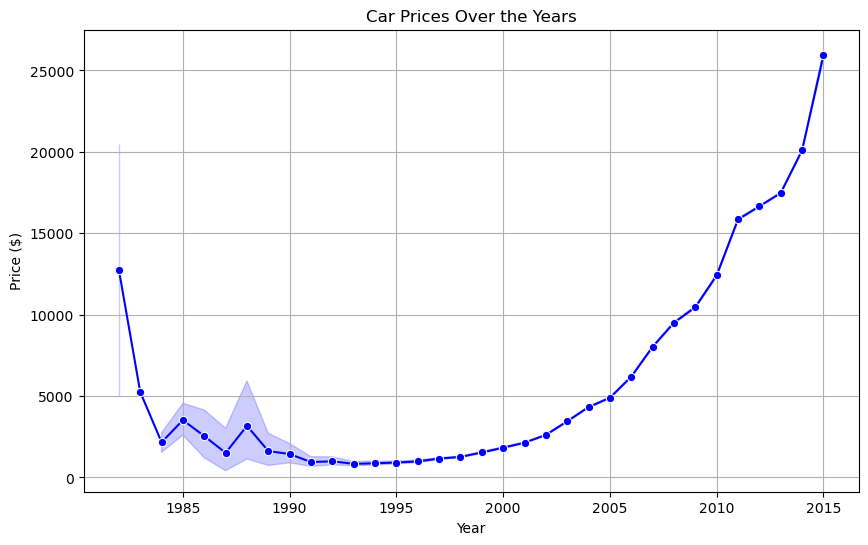

In [7]:
# Plotting using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='sellingprice', data=df, marker='o', color='b')
plt.title('Car Prices Over the Years')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

In [8]:
def clean_and_parse_datetime(dt_str):
        # Define a regex pattern to match the year (four digits) in the datetime string
        year_pattern = r"[^0-9].* \d\d (\d{4}).*"
        
        # Use regex to find the year in the datetime string
        match = re.search(year_pattern, str(dt_str))
        
        if match:
            year_str = match.group(1)  # Extract the matched year as a string
            year = int(year_str)      # Convert the extracted year string to an integer
            return year
        else:
            return None  # Return NaT (Not a Time) if no year is found in the datetime string


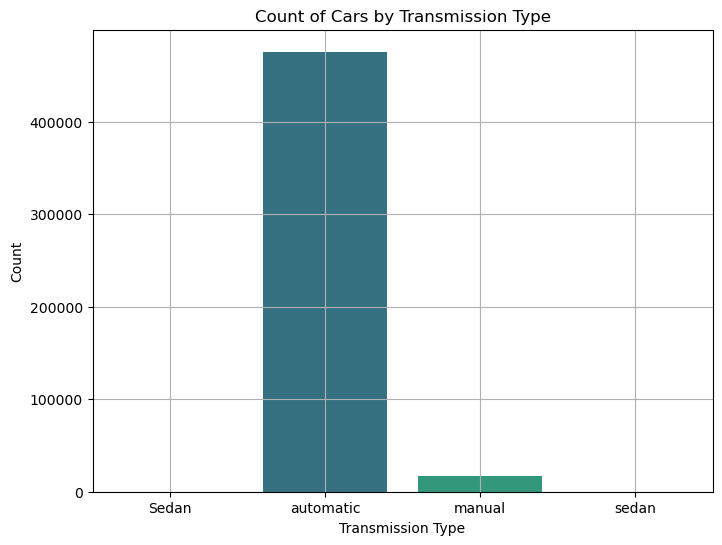

In [9]:
# Group by 'TransmissionType' and count occurrences
transmission_counts = df.groupby('transmission').size().reset_index(name='Count')

# Plotting using seaborn
plt.figure(figsize=(8, 6))
sns.barplot(x='transmission', y='Count', data=transmission_counts, palette='viridis')
plt.title('Count of Cars by Transmission Type')
plt.xlabel('Transmission Type')
plt.ylabel('Count')
plt.grid(True)
plt.show()

In [10]:
df = df.sample(n=50000, random_state=42)  # Set random_state for reproducibility

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 509547 to 535996
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   year          50000 non-null  int64  
 1   make          49044 non-null  object 
 2   model         49033 non-null  object 
 3   trim          49018 non-null  object 
 4   body          48793 non-null  object 
 5   transmission  44163 non-null  object 
 6   vin           49999 non-null  object 
 7   state         50000 non-null  object 
 8   condition     48914 non-null  float64
 9   odometer      49992 non-null  float64
 10  color         49937 non-null  object 
 11  interior      49937 non-null  object 
 12  seller        50000 non-null  object 
 13  mmr           49996 non-null  float64
 14  sellingprice  50000 non-null  float64
 15  saledate      50000 non-null  object 
dtypes: float64(4), int64(1), object(11)
memory usage: 6.5+ MB


In [12]:
# Clean and parse 'saledate' column
df['saleyear'] = df['saledate'].apply(clean_and_parse_datetime)

# Calculate the difference in years between 'saledate' and 'Year'
df['years_on_sale'] = (df['saleyear'] - df['year'])

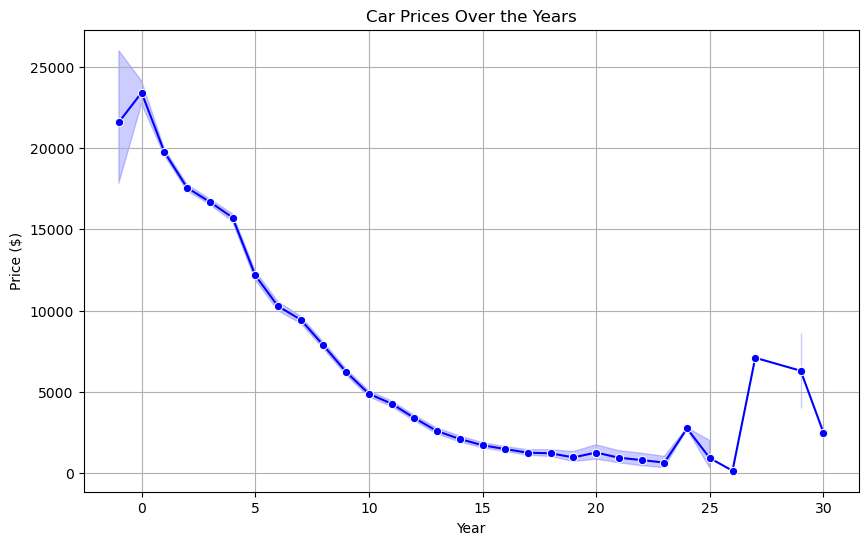

In [13]:
# Plotting using seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='years_on_sale', y='sellingprice', data=df, marker='o', color='b')
plt.title('Car Prices Over the Years')
plt.xlabel('Year')
plt.ylabel('Price ($)')
plt.grid(True)
plt.show()

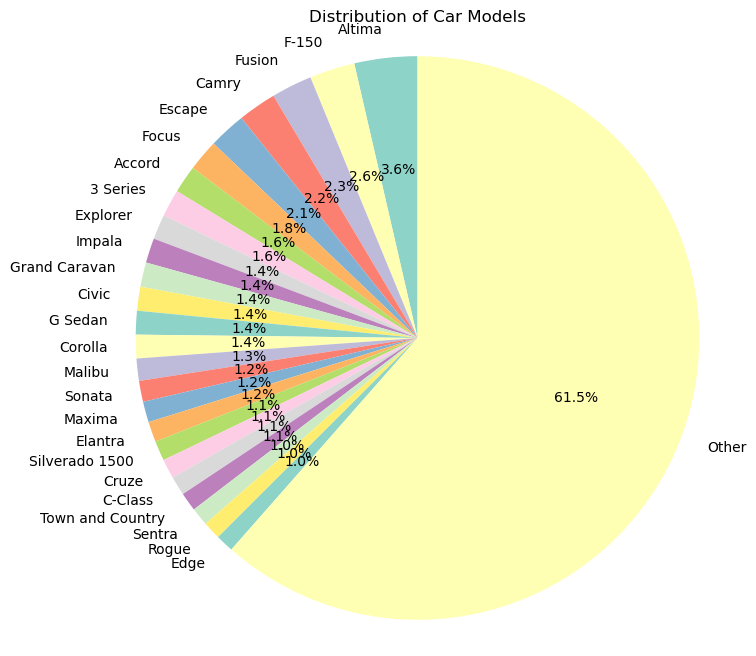

In [20]:
# Calculate value counts of car models
model_counts = df['model'].value_counts()

# Calculate percentages
total_count = len(df)
model_percentages = model_counts / total_count * 100

# Threshold percentage to determine categories to group into "Other"
threshold = 1  # Categories with less than 1% will be grouped into "Other"

# Group categories below the threshold into "Other"
small_categories = model_percentages[model_percentages < threshold]
model_counts['Other'] = model_counts[small_categories.index].sum()
model_counts.drop(small_categories.index, inplace=True)

# Plotting a pie chart using matplotlib
plt.figure(figsize=(8, 8))  # Set the figure size (square for a circular pie chart)

# Plot the pie chart
plt.pie(model_counts, labels=model_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title('Distribution of Car Models')
plt.axis('equal')  # Ensure the pie chart is drawn as a circle
plt.show()